In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define paths
price_data_path = 'stocknet-dataset/price/preprocessed'

# Initialize lists to store data
all_data = []

# Load data for each stock
for stock_file in os.listdir(price_data_path):
    if stock_file.endswith('.txt'):
        stock_path = os.path.join(price_data_path, stock_file)
        df = pd.read_csv(stock_path, sep='\t', header=None, names=['Date', 'Movement', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df['Stock'] = stock_file.split('.')[0]
        all_data.append(df)

# Combine all data into a single DataFrame
data = pd.concat(all_data)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by 'Date' and 'Stock'
data.sort_values(by=['Stock', 'Date'], inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[['Date', 'Stock'] + features]

# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])


In [5]:
from sklearn.model_selection import train_test_split

# Parameters
sequence_length = 30  # Number of days to look back
prediction_horizon = 1  # Predict the next day's price

# Step 2: Prepare data for LSTM
def create_sequences(stock_data, seq_length, pred_horizon):
    X, y = [], []
    for i in range(len(stock_data) - seq_length - pred_horizon + 1):
        X.append(stock_data[i:i + seq_length].values)
        y.append(stock_data.iloc[i + seq_length + pred_horizon - 1]['Close'])
    return np.array(X), np.array(y)

X, y = [], []
for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock][features]
    X_stock, y_stock = create_sequences(stock_data, sequence_length, prediction_horizon)
    X.append(X_stock)
    y.append(y_stock)

# Combine sequences from all stocks
X = np.vstack(X)
y = np.concatenate(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


2024-11-23 03:42:46.602897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732333366.619935     922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732333366.624812     922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 03:42:46.643687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50


W0000 00:00:1732333368.434929     922 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0050 - val_loss: 1.0389e-04
Epoch 2/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 3.7224e-04 - val_loss: 1.0429e-04
Epoch 3/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 1.2292e-04 - val_loss: 1.0171e-04
Epoch 4/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 1.2861e-04 - val_loss: 1.0005e-04
Epoch 5/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 1.1558e-04 - val_loss: 9.9906e-05
Epoch 6/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 1.1932e-04 - val_loss: 1.0123e-04
Epoch 7/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 1.1464e-04 - val_loss: 9.9905e-05
Epoch 8/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 1.0257e-04 - val_loss: 9.9854e-05
Epoch 9/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 1.1665e-04 - val_loss: 1.0141e-04
Epoch 10/50
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 1.0963e-04 - val_loss: 1.0324e-04
Epoch 11/50
2382/2382 ━━━━━━━━━━━━

In [7]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], len(features) - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], len(features) - 1)), y_pred), axis=1))[:, -1]

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3078e-04
Test Loss: 0.00012077714200131595
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
MAE: 812293.3915746786
RMSE: 6776574.17186505


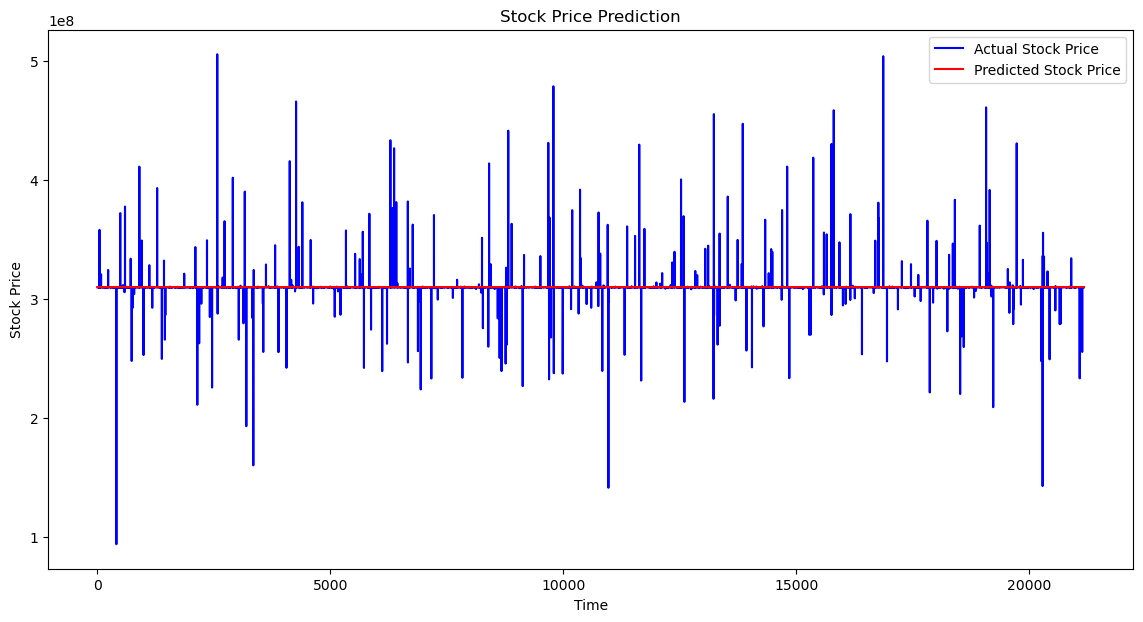

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, color='blue', label='Actual Stock Price')
plt.plot(y_pred_inv, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
